In [142]:
#SET ALPHA
ALPHA = 0.8

In [143]:
import re
def get_num_references(text):
    numref = len(re.findall('@', text))
    return numref

def get_num_hashtags(text):
    numref = len(re.findall('#', text))
    return numref

def get_num_links(text):
    numlinks = len(re.findall('https?:\/\/', text))
    return numlinks

def remove_links(text):
    clean_text = re.sub('https?:\/\/.*\..+\/.*\s?', '', text)
    return clean_text

def remove_reference(text):
    clean_text = re.sub('@\w+(\s|:)?', '', text)
    return clean_text

def swap_time(text):
    re_time = re.compile(r'\d{1,2}:\d\d[ ]?(am|pm)?')
    re_time.sub(' TIME ',text)
    return text

def clean_text(text):
    return re.sub('[^a-zA-Z0-9]', ' ', text)

def preprocess_text(text):
    return clean_text(swap_time(remove_links(remove_reference(text))))

def compute_engagement_score(retweets,fav):
    return ALPHA*retweets+(1-ALPHA)*fav
    
def get_day_hour(text):
    m = re.match("^\w\w\w \w\w\w \d\d (\d\d)*", text)
    return int(m.group(1))

def get_weekday_mon(text, day):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "day") else 0

In [144]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

data = pd.read_csv('NYUDS_realdonaldtrump_final_nolinebreaks.csv',
                       header = None, 
                       names = ['D','T','R','F','NA'], encoding = "ISO-8859-1")



In [145]:
data['Y'] = pd.DataFrame(compute_engagement_score(data['R'], data['F']))

In [146]:
data.head()

,D,T,R,F,NA,Y
0,Wed Dec 09 20:41:17 +0000 2015,"""Carter Banned Iranians From Coming To U.S. Du...",3511,2090,False,3226.8
1,Wed Dec 09 20:33:53 +0000 2015,""" Haim Saban: Hillary ClintonÛªs Top Hollywoo...",1822,1094,False,1676.4
2,Wed Dec 09 19:21:31 +0000 2015,The police in London say IÛªm right. Major ar...,3496,2222,False,3241.2
3,Wed Dec 09 18:46:12 +0000 2015,Thank you @JebBush- you finally get it! https:...,3030,1176,False,2659.2
4,Wed Dec 09 16:13:22 +0000 2015,"Thank you, Piers, they don't know what they're...",5624,2554,False,5010.0


In [147]:
from sklearn.cross_validation import train_test_split
import numpy as np

X = data['T']

Y =  np.where(data['Y']>=np.mean(data['Y']), 1, 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [150]:
X_train.head()

279     The numbers at the @nytimes  are so dismal, es...
869     "@UnitedCitizen01: @DanScavino @realDonaldTrum...
497     "@syoka68: Reading the comments of the leftist...
2555    Trump Will Make America GREAT!!!!  #ChangeTheW...
654               Amazing evening at Saturday Night Live!
Name: T, dtype: object

In [152]:
X_train = pd.DataFrame(X_train.map(preprocess_text))
X_test = pd.DataFrame(X_test.map(preprocess_text))

In [153]:
X_train.head()

,T
279,The numbers at the are so dismal especially ...
869,Would be AWESOME moderators for next debate ...
497,Reading the comments of the leftists on here...
2555,Trump Will Make America GREAT ChangeTheW...
654,Amazing evening at Saturday Night Live


In [154]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

binary_vectorizer = CountVectorizer(binary=True, stop_words='english', max_features=3000,ngram_range=(1, 2))
binary_vectorizer.fit(X_train['T'])
X_train_binary = binary_vectorizer.transform(X_train['T'])
X_test_binary = binary_vectorizer.transform(X_test['T'])

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(X_train['T'])
X_train_tfidf = tfidf_vectorizer.transform(X_train['T'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['T'])

In [155]:
X_train_binary

<2398x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 20280 stored elements in Compressed Sparse Row format>

In [156]:
# Run this so your plots show properly
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12

Area under the ROC curve on the test data = 0.704
Area under the ROC curve on the test data = 0.702
Area under the ROC curve on the test data = 0.688
Area under the ROC curve on the test data = 0.710


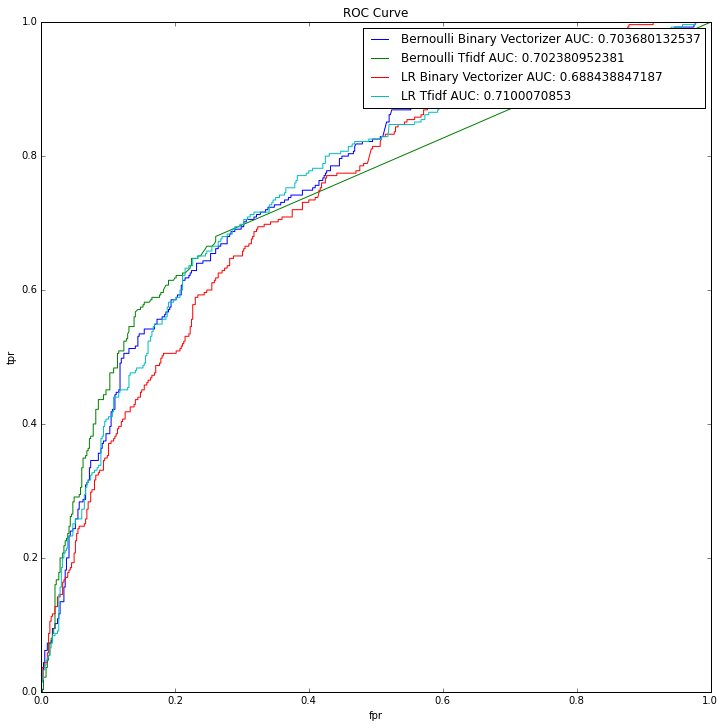

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

tprs = []
fprs = []
roc_labels = []

# Model
model = BernoulliNB()
model.fit(X_train_binary, Y_train)

auc_score = metrics.roc_auc_score(model.predict(X_test_binary), Y_test)
print ("Area under the ROC curve on the test data = %.3f" % auc_score)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Bernoulli Binary Vectorizer AUC: " + str(auc_score))
ax = plt.subplot()
plt.plot(fpr, tpr, label=roc_labels[0])
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])

# Model
model = BernoulliNB()
model.fit(X_train_tfidf, Y_train)

auc_score = metrics.roc_auc_score(model.predict(X_test_tfidf), Y_test)
print ("Area under the ROC curve on the test data = %.3f" % auc_score)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Bernoulli Tfidf AUC: " + str(auc_score))
ax = plt.subplot()
plt.plot(fpr, tpr, label=roc_labels[1])
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])

# Model
model = LogisticRegression()
model.fit(X_train_binary, Y_train)

auc_score = metrics.roc_auc_score(model.predict(X_test_binary), Y_test)
print ("Area under the ROC curve on the test data = %.3f" % auc_score)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("LR Binary Vectorizer AUC: " + str(auc_score))
ax = plt.subplot()
plt.plot(fpr, tpr, label=roc_labels[2])
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

auc_score = metrics.roc_auc_score(model.predict(X_test_tfidf), Y_test)
print ("Area under the ROC curve on the test data = %.3f" % auc_score)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("LR Tfidf AUC: " + str(auc_score))
ax = plt.subplot()
plt.plot(fpr, tpr, label=roc_labels[3])
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()